In [1]:
import numpy as np
import matplotlib.pyplot as plt
from detchar.analysis import fts_utils as ftsu

In [2]:
fts_set = ftsu.FtsMeasurementSet('/home/pcuser/qsp/src/nistqsptdm/detchar/analysis/howto/example_data/20241126/')

In [3]:
fts_set.print_measurement_metadata()



Measurement number:  0
file_prefix :: rs29
comment :: db=5050; Tb=120mK; polarizer=0; aperture=1"
source :: 1050C
file_number_list :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
speed :: 5.0
num_scans :: 10
num_samples :: 14543




In [6]:
fts_set.filename_list

['rs29_120731_0000_ifg.csv',
 'rs29_120731_0001_ifg.csv',
 'rs29_120731_0002_ifg.csv',
 'rs29_120731_0003_ifg.csv',
 'rs29_120731_0004_ifg.csv',
 'rs29_120731_0005_ifg.csv',
 'rs29_120731_0006_ifg.csv',
 'rs29_120731_0007_ifg.csv',
 'rs29_120731_0008_ifg.csv',
 'rs29_120731_0009_ifg.csv']

file_prefix :: rs29
comment :: db=5050; Tb=120mK; polarizer=0; aperture=1"
source :: 1050C
file_number_list :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
speed :: 5.0
num_scans :: 10
num_samples :: 14543


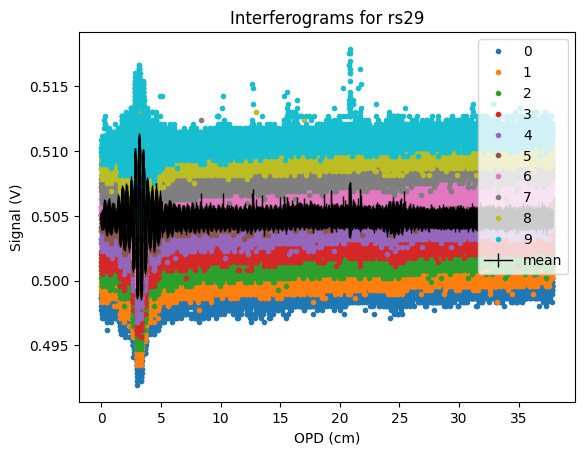

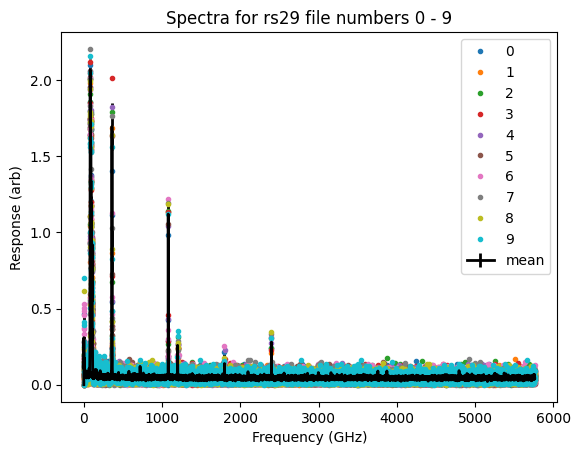

In [4]:
fts_set.plot_all_measurements()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Frequency (GHz)', ylabel='Response (arb)'>)

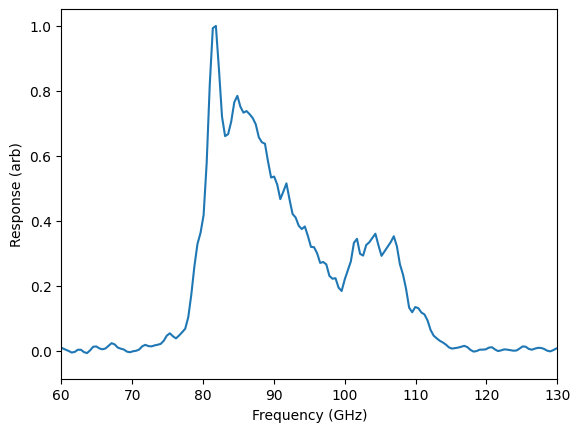

In [10]:
fts_set.plot_measurements(xlim=(60,130))